DATA PROCESS

In [ ]:
from __future__ import annotations
import argparse, csv, math
from pathlib import Path
from typing import List, Tuple

import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
"""
==============================
1. CSV ➜ YOLO labels (cx cy w h нормалізовано)
2. Приведення bbox до валідних координат (clip 0…W/H)
3. Обробка порожніх сцен (-1 -1 -1 -1)
4. Тайлінг 640×640 з overlap 25 %, min_area 20 %, ≤20 % negative tiles
"""

# ──────────────────────────── helpers ────────────────────────────────── #

CLASS_MAP = {0: "explosive", 1: "anti_personnel", 2: "anti_vehicle"}  # для читабельності

def clip(val: float, lo: float, hi: float) -> float:
    return max(lo, min(val, hi))

def csv_row_to_abs(row: dict) -> Tuple[int, int, int, int, int]:
    """
    CSV → (cls, x_min, y_min, x_max, y_max)
    Обов’язково кліпаємо координати у межах картинки (іноді розмітка «виїжджає» назовні).
    """
    cls = int(row["label"])
    x_min = int(row["x"])
    y_min = int(row["y"])
    w, h = int(row["width"]), int(row["height"])
    img_w, img_h = int(row["image_width"]), int(row["image_height"])
    x_max = clip(x_min + w, 0, img_w)
    y_max = clip(y_min + h, 0, img_h)
    x_min = clip(x_min, 0, img_w)
    y_min = clip(y_min, 0, img_h)
    return cls, x_min, y_min, x_max, y_max

def abs_to_yolo(x0, y0, x1, y1, img_w, img_h):
    bw, bh = x1 - x0, y1 - y0
    cx, cy = x0 + bw / 2, y0 + bh / 2
    return cx / img_w, cy / img_h, bw / img_w, bh / img_h

def intersect(box, tile):
    bx0, by0, bx1, by1 = box
    tx0, ty0, tx1, ty1 = tile
    ix0, iy0 = max(bx0, tx0), max(by0, ty0)
    ix1, iy1 = min(bx1, tx1), min(by1, ty1)
    if ix0 >= ix1 or iy0 >= iy1:
        return None, 0.0
    inter_area = (ix1 - ix0) * (iy1 - iy0)
    orig_area = (bx1 - bx0) * (by1 - by0)
    return (ix0, iy0, ix1, iy1), inter_area / orig_area

In [ ]:
# ─────────────────────── 1. CSV ➜ temp YOLO  ────────────────────────── #

def csv_to_yolo(csv_path: Path, yolo_path: Path):
    """
    Конвертує один .csv у YOLO‑txt.
    Якщо в .csv лише рядок «‑1 ‑1 ‑1 ‑1» → створює порожній файл (negative scene).
    """
    with csv_path.open() as f_in, yolo_path.open("w") as f_out:
        reader = csv.DictReader(f_in)
        empty_scene = True
        for row in reader:
            if row["x"] == "-1":  # офіційний маркер порожньої сцени
                continue
            empty_scene = False
            cls, x0, y0, x1, y1 = csv_row_to_abs(row)
            img_w, img_h = int(row["image_width"]), int(row["image_height"])
            cx, cy, bw, bh = abs_to_yolo(x0, y0, x1, y1, img_w, img_h)
            f_out.write(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")
        if empty_scene:
            # створюємо порожній файл, щоб скрипт тайлінгу знав: negative scene
            pass


In [ ]:

# ─────────────────────── 2. Tile generator  ─────────────────────────── #

def tile_image(
    img_path: Path,
    yolo_path: Path,
    dst_img: Path,
    dst_lbl: Path,
    tile=640,
    overlap=0.25,
    min_area=0.2,
    max_neg_ratio=0.2,
):
    img = cv2.imread(str(img_path))
    if img is None:
        raise IOError(img_path)
    H, W = img.shape[:2]

    # читаємо тимчасові YOLO‑бокси (або порожній список)
    labels = []
    if yolo_path.exists() and yolo_path.stat().st_size:
        for line in yolo_path.read_text().splitlines():
            cls, cx, cy, bw, bh = map(float, line.split())
            bx0 = (cx - bw / 2) * W
            by0 = (cy - bh / 2) * H
            bx1 = (cx + bw / 2) * W
            by1 = (cy + bh / 2) * H
            labels.append((int(cls), bx0, by0, bx1, by1))

    stride = int(tile * (1 - overlap))
    nx = math.ceil((W - tile) / stride) + 1
    ny = math.ceil((H - tile) / stride) + 1
    neg_allowed = math.ceil(nx * ny * max_neg_ratio)
    neg_cnt = 0

    for iy in range(ny):
        for ix in range(nx):
            x0, y0 = ix * stride, iy * stride
            x1, y1 = clip(x0 + tile, 0, W), clip(y0 + tile, 0, H)

            patch = img[y0:y1, x0:x1]
            # паддінг, якщо обітнутий край
            if patch.shape[0] < tile or patch.shape[1] < tile:
                patch = cv2.copyMakeBorder(
                    patch,
                    0,
                    tile - patch.shape[0],
                    0,
                    tile - patch.shape[1],
                    cv2.BORDER_CONSTANT,
                    value=(114, 114, 114),
                )

            tile_boxes: List[str] = []
            for cls, bx0, by0, bx1, by1 in labels:
                clipped, ioa = intersect((bx0, by0, bx1, by1), (x0, y0, x1, y1))
                if ioa >= min_area:
                    cx, cy, bw, bh = abs_to_yolo(
                        clipped[0] - x0, clipped[1] - y0,
                        clipped[2] - x0, clipped[3] - y0,
                        tile, tile
                    )
                    tile_boxes.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

            # баланс негативів
            if not tile_boxes and neg_cnt >= neg_allowed:
                continue
            if not tile_boxes:
                neg_cnt += 1

            name = f"{img_path.stem}_{iy}_{ix}"
            cv2.imwrite(str(dst_img / f"{name}.jpg"), patch)
            (dst_lbl / f"{name}.txt").write_text("\n".join(tile_boxes))


In [ ]:
# ------------------- IMPORTS -------------------------------------------------
from pathlib import Path
from itertools import chain
from tqdm.notebook import tqdm

# якщо функції csv_to_yolo та tile_image лежать у власному модулі:
# from utils.tiling import csv_to_yolo, tile_image

# ------------------- ПАРАМЕТРИ ----------------------------------------------
DATA_ROOT  = Path("/kaggle/input/uadamage-demining-competition")
TRAIN_DIR  = DATA_ROOT / "train"           # містить images/ та annotations/
TEST_DIR   = DATA_ROOT / "test"            # (не використовується тут, але лишив як приклад)

OUT_DIR    = Path("/kaggle/working/out")   # тут збережемо готові тайли
TMP_DIR    = Path("/kaggle/working/tmp")   # тимчасові YOLO‑мітки

TILE_SIZE  = 640
OVERLAP    = 0.25
MIN_AREA   = 0.20
MAX_NEG    = 0.20

# ------------------- ШЛЯХИ ---------------------------------------------------
IMG_DIR   = TRAIN_DIR / "images"
ANN_DIR   = TRAIN_DIR / "annotations"
OUT_IMG   = OUT_DIR / "images"
OUT_LBL   = OUT_DIR / "labels"

# створюємо потрібні writable‑теки
for p in (OUT_IMG, OUT_LBL, TMP_DIR):
    p.mkdir(parents=True, exist_ok=True)

# ------------------- ЗБІР СПИСКУ ЗОБРАЖЕНЬ -----------------------------------
IMG_EXTS = ("*.jpg", "*.jpeg", "*.JPG", "*.JPEG")
image_paths = list(chain.from_iterable(IMG_DIR.glob(p) for p in IMG_EXTS))

print(f"Знайдено {len(image_paths)} зображень")

# ------------------- ОСНОВНИЙ ЦИКЛ ------------------------------------------
i=0
for img_path in tqdm(sorted(image_paths), desc="CSV → YOLO & tiling"):
    csv_path = ANN_DIR / f"{img_path.stem}.csv"
    if not csv_path.exists():
        # CSV відсутній → пропускаємо (часто буває, наприклад, для test‑кадрів)
        print(f"[WARN] {csv_path.name} відсутній, пропускаю")
        continue

    tmp_lbl = TMP_DIR / f"{img_path.stem}.txt"

    # 1) CSV → тимчасовий YOLO
    csv_to_yolo(csv_path, tmp_lbl)

    # 2) Тайлимо зображення + мітки
    tile_image(
        img_path,
        tmp_lbl,
        OUT_IMG,
        OUT_LBL,
        tile=TILE_SIZE,
        overlap=OVERLAP,
        min_area=MIN_AREA,
        max_neg_ratio=MAX_NEG,
    )

    # 3) Видаляємо тимчасовий файл
    tmp_lbl.unlink()
    i += 1
    if i>5000:
        break


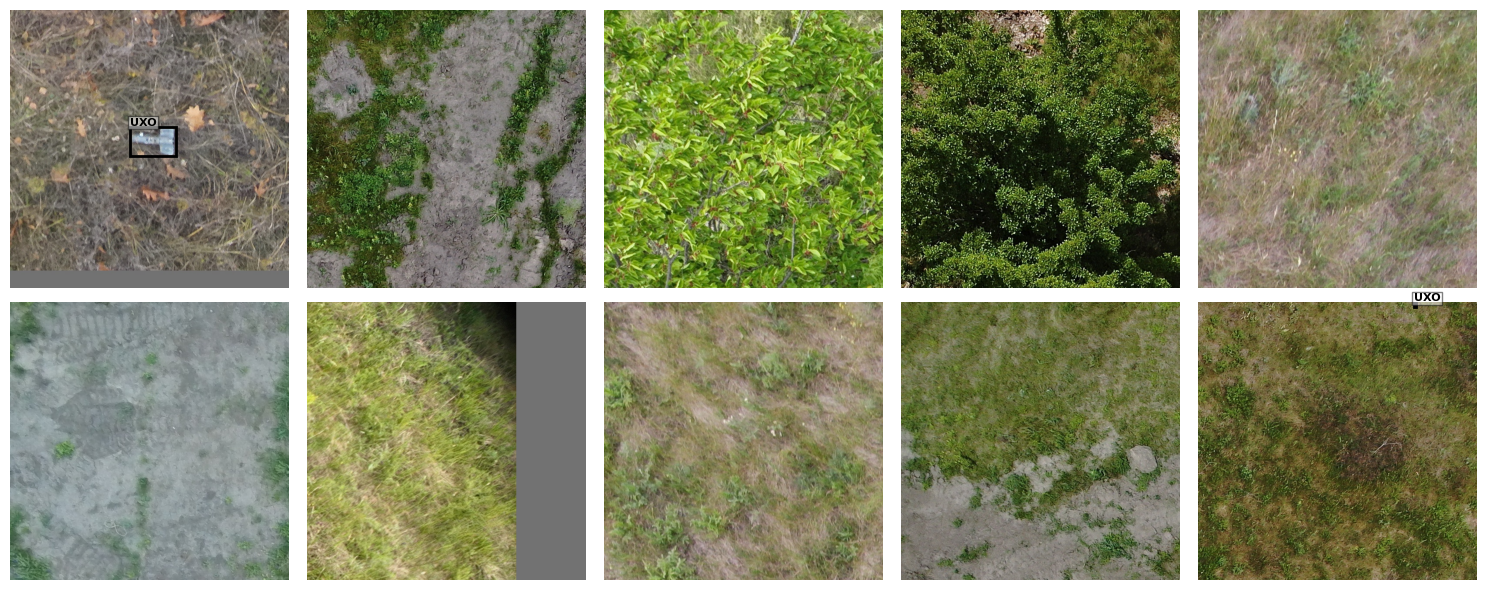

In [9]:
#VIZ
# ------------------- IMPORTS -------------------------------------------------
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------- ПАРАМЕТРИ ----------------------------------------------
IMG_DIR = Path("/kaggle/working/out/images")   # де лежать тайли (або train/images)
LBL_DIR = Path("/kaggle/working/out/labels")   # відповідні .txt‑файли
EXTS    = ("*.jpg", "*.jpeg", "*.png")         # розширення зображень
N_SHOW  = 10                                   # скільки показати
RANDOM  = True                                 # True → випадкові; False → перші N_SHOW

# Якщо хочете відображати назви класів, упишіть їх у список нижче
CLASS_NAMES = [
    "UXO",    # id 0
    "Other",  # id 1
]

# ------------------- ЗБІР ФАЙЛІВ --------------------------------------------
images = []
for pat in EXTS:
    images.extend(IMG_DIR.glob(pat))

if len(images) < N_SHOW:
    raise ValueError(f"У теці лише {len(images)} файлів — треба ≥ {N_SHOW}")

images = random.sample(images, N_SHOW) if RANDOM else images[:N_SHOW]

# ------------------- ВІЗУАЛІЗАЦІЯ -------------------------------------------
n_cols, n_rows = 5, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))

for ax, img_path in zip(axes.flatten(), images):
    # --- зображення ---
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    ax.imshow(img)

    # --- шукаємо label-файл ---
    lbl_path = LBL_DIR / (img_path.stem + ".txt")
    if lbl_path.exists():
        with lbl_path.open() as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.split())
                # YOLO координати → пікселі
                x0 = (xc - bw/2) * w
                y0 = (yc - bh/2) * h
                box_w = bw * w
                box_h = bh * h
                # прямокутник
                rect = patches.Rectangle(
                    (x0, y0), box_w, box_h,
                    linewidth=2,
                    fill=False,
                )
                ax.add_patch(rect)
                # напис класу (за наявності)
                cls_id = int(cls)
                if 0 <= cls_id < len(CLASS_NAMES):
                    ax.text(
                        x0, y0 - 2,
                        CLASS_NAMES[cls_id],
                        fontsize=8,
                        weight="bold",
                        bbox=dict(facecolor="white", alpha=0.5, pad=1),
                    )
    else:
        ax.set_title("label not found", fontsize=8, color="red")

    ax.set_axis_off()

plt.tight_layout()
plt.show()


In [12]:
!pip install ultralytics
!pip install wandb
!yolo settings wandb=True
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=wandb_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00:00:0100:01
  Attempting unins

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dontdodataa (dontdodataa-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# import os
# import csv
# import glob
# import shutil
# import random
# from pathlib import Path
# #/kaggle/input/uadamage-demining-competition/train
# # Config
# BASE_DIR = "/kaggle/input/uadamage-demining-competition/"
# BASE_OUTPUT_DIR = "/kaggle/working/"
# ANNOTATIONS_DIR = BASE_DIR + "train/annotations"
# IMAGES_DIR = BASE_DIR + "train/images"
# OUTPUT_LABELS_DIR = BASE_OUTPUT_DIR + "labels"
# OUTPUT_IMAGES_DIR = BASE_OUTPUT_DIR + "images"
# TRAIN_SPLIT = 0.8

# # Make output directories
# (Path(OUTPUT_LABELS_DIR) / "train").mkdir(parents=True, exist_ok=True)
# (Path(OUTPUT_LABELS_DIR) / "val").mkdir(parents=True, exist_ok=True)
# (Path(OUTPUT_IMAGES_DIR) / "train").mkdir(parents=True, exist_ok=True)
# (Path(OUTPUT_IMAGES_DIR) / "val").mkdir(parents=True, exist_ok=True)

# # Collect all CSV annotation files
# csv_files = glob.glob(os.path.join(ANNOTATIONS_DIR, "*.csv"))

# # Shuffle and split
# random.shuffle(csv_files)
# split_idx = int(len(csv_files) * TRAIN_SPLIT)
# train_files = csv_files[:split_idx]
# val_files = csv_files[split_idx:]

# def convert_and_save(csv_path, label_output_dir, image_output_dir):
#     with open(csv_path, newline='') as csvfile:
#         reader = csv.DictReader(csvfile)
#         yolo_lines = []
#         image_name = None
#         for row in reader:
#             image_name = row["image_id"]
#             x = float(row["x"])
#             y = float(row["y"])
#             w = float(row["width"])
#             h = float(row["height"])
#             img_w = float(row["image_width"])
#             img_h = float(row["image_height"])
#             cls = row["label"]

#             # Convert to YOLO format: normalized center x, y, width, height
#             x_center = (x + w / 2) / img_w
#             y_center = (y + h / 2) / img_h
#             w_norm = w / img_w
#             h_norm = h / img_h

#             yolo_line = f"{cls} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
#             yolo_lines.append(yolo_line)

#         if image_name:
#             # Save label file
#             label_path = os.path.join(label_output_dir, f"{image_name}.txt")
#             with open(label_path, "w") as f:
#                 f.write("\n".join(yolo_lines))

#             # Copy image file to appropriate folder
#             for ext in [".jpg", ".png"]:
#                 image_path = os.path.join(IMAGES_DIR, f"{image_name}{ext}")
#                 if os.path.exists(image_path):
#                     shutil.copy(image_path, os.path.join(image_output_dir, f"{image_name}{ext}"))
#                     break

# # Convert files
# for file in train_files:
#     convert_and_save(file, f"{OUTPUT_LABELS_DIR}/train", f"{OUTPUT_IMAGES_DIR}/train")

# for file in val_files:
#     convert_and_save(file, f"{OUTPUT_LABELS_DIR}/val", f"{OUTPUT_IMAGES_DIR}/val")



In [11]:
# import os
# import cv2
# from tqdm import tqdm

# # Configuration
# input_image_dirs = [BASE_OUTPUT_DIR + 'images/train', BASE_OUTPUT_DIR + 'images/val']
# input_label_dirs = [BASE_OUTPUT_DIR+'labels/train', 'labels/val']
# output_image_root = 'cropped/images'
# output_label_root = 'cropped/labels'
# tile_size = 640
# overlap = 80

# os.makedirs(output_image_root, exist_ok=True)
# os.makedirs(output_label_root, exist_ok=True)

# def ensure_dir(path):
#     os.makedirs(os.path.dirname(path), exist_ok=True)

# def crop_and_save(image, label_lines, img_path, label_path, save_prefix):
#     h, w = image.shape[:2]
#     h_effective = max(h, tile_size)
#     w_effective = max(w, tile_size)

#     stride_x = tile_size - overlap
#     stride_y = tile_size - overlap

#     num_x = max(1, (w_effective - overlap) // stride_x)
#     num_y = max(1, (h_effective - overlap) // stride_y)

#     for y_idx in range(num_y):
#         for x_idx in range(num_x):
#             x_start = min(x_idx * stride_x, w - tile_size) if w > tile_size else 0
#             y_start = min(y_idx * stride_y, h - tile_size) if h > tile_size else 0
#             x_end = x_start + tile_size
#             y_end = y_start + tile_size

#             tile = image[y_start:y_end, x_start:x_end]
#             tile_h, tile_w = tile.shape[:2]
#             tile_labels = []

#             for line in label_lines:
#                 cls, x_center, y_center, w_norm, h_norm = map(float, line.strip().split())
#                 abs_x = x_center * w
#                 abs_y = y_center * h
#                 abs_w = w_norm * w
#                 abs_h = h_norm * h

#                 x0 = abs_x - abs_w / 2
#                 y0 = abs_y - abs_h / 2
#                 x1 = abs_x + abs_w / 2
#                 y1 = abs_y + abs_h / 2

#                 # Check if object is within the current tile
#                 if x1 < x_start or x0 > x_end or y1 < y_start or y0 > y_end:
#                     continue

#                 # Clip to the tile bounds
#                 clipped_x0 = max(x0, x_start)
#                 clipped_y0 = max(y0, y_start)
#                 clipped_x1 = min(x1, x_end)
#                 clipped_y1 = min(y1, y_end)

#                 # Convert to tile-relative YOLO format
#                 new_w = clipped_x1 - clipped_x0
#                 new_h = clipped_y1 - clipped_y0
#                 new_x_center = (clipped_x0 + new_w / 2) - x_start
#                 new_y_center = (clipped_y0 + new_h / 2) - y_start

#                 tile_labels.append(f"{int(cls)} {new_x_center/tile_w:.6f} {new_y_center/tile_h:.6f} {new_w/tile_w:.6f} {new_h/tile_h:.6f}")

#             # Save tile and labels
#             tile_name = f"{save_prefix}_x{x_idx}_y{y_idx}"
#             image_out_path = os.path.join(output_image_root, tile_name + '.jpg')
#             label_out_path = os.path.join(output_label_root, tile_name + '.txt')

#             ensure_dir(image_out_path)
#             ensure_dir(label_out_path)
#             cv2.imwrite(image_out_path, tile)

#             with open(label_out_path, 'w') as f:
#                 f.write("\n".join(tile_labels))

#     # Delete original files to save space
#     os.remove(img_path)
#     if os.path.exists(label_path):
#         os.remove(label_path)

# for img_dir, lbl_dir in zip(input_image_dirs, input_label_dirs):
#     image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

#     for img_file in tqdm(image_files, desc=f"Processing {img_dir}"):
#         image_path = os.path.join(img_dir, img_file)
#         label_path = os.path.join(lbl_dir, os.path.splitext(img_file)[0] + '.txt')

#         image = cv2.imread(image_path)
#         if image is None:
#             continue

#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label_lines = f.readlines()
#         else:
#             label_lines = []

#         save_prefix = os.path.splitext(img_file)[0]
#         crop_and_save(image, label_lines, image_path, label_path, save_prefix)

# print("✅ Cropping complete. Original files deleted.")


Processing /kaggle/working/images/train:  87%|████████▋ | 1793/2064 [06:49<01:01,  4.37it/s]


OSError: [Errno 28] No space left on device: '/kaggle/working/cropped/labels/3e412e4f8f2464778c001bb1f87f93ab86f5aace2969f40fbef5a2520aac6271_x3_y5.txt'

In [1]:
# import os
# import random
# import shutil
# from pathlib import Path

# # Set paths
# base_dir = Path("/kaggle/working")
# out_images = base_dir / "out/images"
# out_labels = base_dir / "out/labels"
# val_images = base_dir / "val/images"
# val_labels = base_dir / "val/labels"

# # Create val folders if they don't exist
# val_images.mkdir(parents=True, exist_ok=True)
# val_labels.mkdir(parents=True, exist_ok=True)

# # Get all image files
# image_files = list(out_images.glob("*.jpg")) + list(out_images.glob("*.png"))

# # Shuffle and select 20%
# random.seed(42)
# val_sample = random.sample(image_files, int(0.2 * len(image_files)))

# # Move image and corresponding label
# for img_path in val_sample:
#     label_path = out_labels / (img_path.stem + ".txt")

#     shutil.move(str(img_path), str(val_images / img_path.name))
#     if label_path.exists():
#         shutil.move(str(label_path), str(val_labels / label_path.name))

# print(f"Moved {len(val_sample)} images and corresponding labels to /val.")


Moved 0 images and corresponding labels to /val.


In [13]:
yaml_content = """
path: /kaggle/working
train: out/images
val: val/images

names:
  0: Explosives
  1: Anti-personnel minу
  2: Anti-vehicle mine
"""

with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write(yaml_content.strip() + "\n")

In [15]:
from ultralytics import YOLO
model = YOLO("yolo12m.pt")
results = model.train(data="/kaggle/working/dataset.yaml", epochs=25,
                      project="yolo", name="yolo12m", batch=8, device=[0,1], mosaic=False)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12m.pt, momentum=0.937, mosaic=False, multi_scale=False, name=yolo12m2, nbs=64, nms=False, opset=None, optimize=False, optimizer=au

wandb: Currently logged in as: dontdodataa (dontdodataa-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250726_154647-n1m01pq2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run yolo12m2
wandb: ⭐️ View project at https://wandb.ai/dontdodataa-igor-sikorsky-kyiv-polytechnic-institute/yolo
wandb: 🚀 View run at https://wandb.ai/dontdodataa-igor-sikorsky-kyiv-polytechnic-institute/yolo/runs/n1m01pq2


Overriding model.yaml nc=80 with nc=3
Transferred 745/751 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1993.6±640.5 MB/s, size: 158.3 KB)


train: Scanning /kaggle/working/out/labels... 86522 images, 77380 backgrounds, 0 corrupt: 100%|██████████| 86522/86522 [01:33<00:00, 921.34it/s] 


train: /kaggle/working/out/images/1de64c4be261f200c1bf2a653e7db5bb65a2571c5a3e54dcc2cbba7d64909a09_3_0.jpg: 1 duplicate labels removed
train: /kaggle/working/out/images/1de64c4be261f200c1bf2a653e7db5bb65a2571c5a3e54dcc2cbba7d64909a09_3_1.jpg: 1 duplicate labels removed
train: /kaggle/working/out/images/1de64c4be261f200c1bf2a653e7db5bb65a2571c5a3e54dcc2cbba7d64909a09_4_1.jpg: 1 duplicate labels removed
train: /kaggle/working/out/images/6dc3361a9305b1ea540db4d136a74b32d5d7026b4b385511c6caa0154d2f534e_4_0.jpg: 1 duplicate labels removed
train: /kaggle/working/out/images/6dc3361a9305b1ea540db4d136a74b32d5d7026b4b385511c6caa0154d2f534e_4_1.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/out/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/data/base.py", line 178, in get_img_files
    assert im_files, f"{self.prefix}No images found in {img_path}. {FORMATS_HELP_MSG}"
           ^^^^^^^^
AssertionError: val: No images found in /kaggle/working/val/images. Supported formats are:
images: {'tif', 'png', 'mpo', 'pfm', 'jpeg', 'heic', 'tiff', 'bmp', 'jpg', 'dng', 'webp'}
videos: {'mp4', 'mov', 'avi', 'ts', 'webm', 'gif', 'asf', 'm4v', 'wmv', 'mkv', 'mpg', 'mpeg'}

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/root/.config/Ultralytics/DDP/_temp_kiv0b190140266614735632.py", line 13, in <module>
    results = trainer.train()
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/trainer.py", line 227, in train
    self._do_train(world_size)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/trainer.py", line 348, i

wandb: 
wandb: 🚀 View run yolo12m2 at: https://wandb.ai/dontdodataa-igor-sikorsky-kyiv-polytechnic-institute/yolo/runs/n1m01pq2
wandb: Find logs at: wandb/run-20250726_154647-n1m01pq2/logs


W0726 15:48:34.667000 189 torch/distributed/elastic/multiprocessing/api.py:897] Sending process 192 closing signal SIGTERM
E0726 15:48:34.831000 189 torch/distributed/elastic/multiprocessing/api.py:869] failed (exitcode: 1) local_rank: 0 (pid: 191) of binary: /usr/bin/python3
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/run.py", line 922, in <module>
    main()
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 355, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/run.py", line 918, in main
    run(args)
  File "/usr/local/lib/python3.11/dist-packages/torch/distributed/run.py", line 909, in run
    elastic_launch(
  File "/usr/local/lib/python3.11/dist-packages/torch/distribute

CalledProcessError: Command '['/usr/bin/python3', '-m', 'torch.distributed.run', '--nproc_per_node', '2', '--master_port', '36659', '/root/.config/Ultralytics/DDP/_temp_kiv0b190140266614735632.py']' returned non-zero exit status 1.

In [16]:
!ls /kaggle/working/val/images